In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import os
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/bi-LSTM, RNN, GRU/Data/AirQualityHoChiMinhCity.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Khám phá dữ liệu ban đầu

               date  Station_No        TSP      PM2.5         O3           CO  \
0  23-02-2021 21:00           1  32.935714  15.604762  55.431381  1330.451429   
1  23-02-2021 22:00           1  30.932353  14.594118  58.197176  1200.603529   
2  23-02-2021 23:00           1  27.645000  13.436667  55.029433  1177.897000   
3  24-02-2021 00:00           1  24.380000  12.365000  54.767700  1267.476000   
4  24-02-2021 01:00           1  22.521667  11.636667  53.786200  1322.293000   

          NO2         SO2  Temperature   Humidity  
0  112.740762  393.000000    28.361905  63.188095  
1  112.366471  377.588235    28.320588  63.773529  
2  112.700433  372.476667    28.336667  64.205000  
3  112.480867  389.070000    28.305000  64.735000  
4  114.331500  393.000000    28.300000  65.188333  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52548 entries, 0 to 52547
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dat

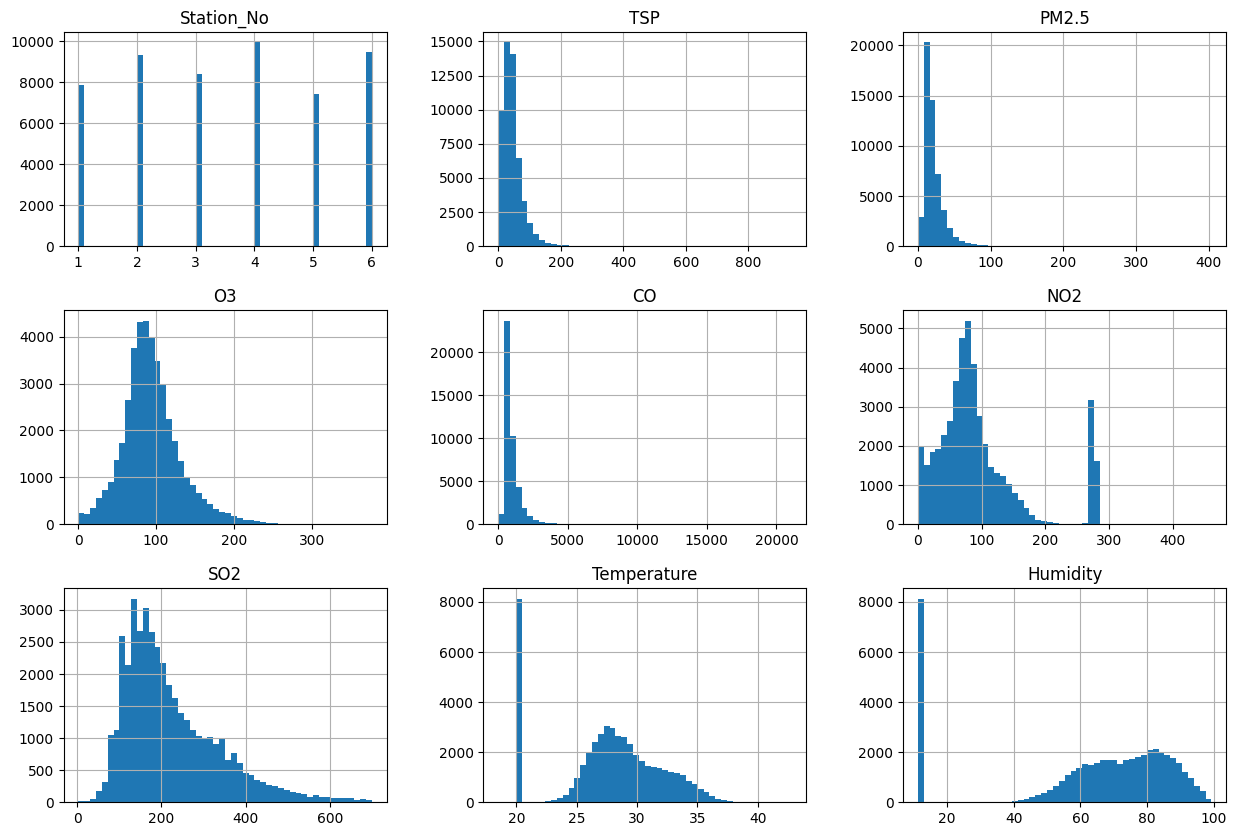

Hệ số tương quan CO vs PM2.5: 0.30


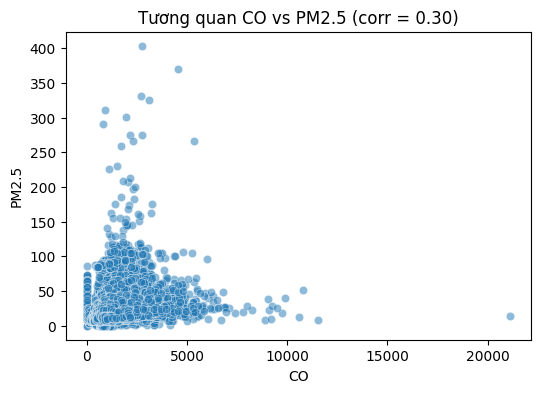

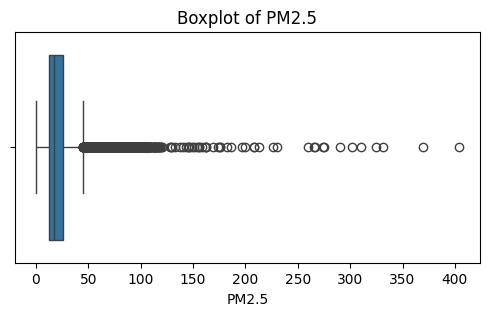

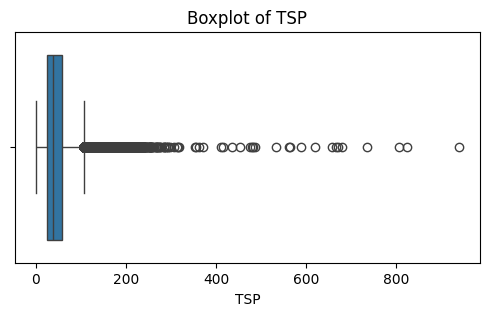

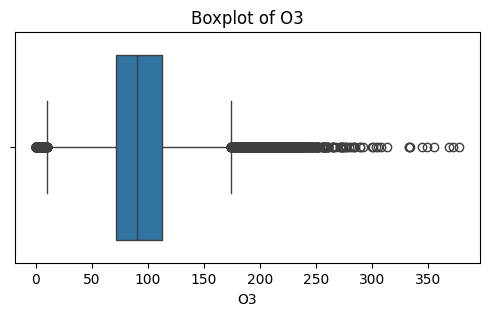

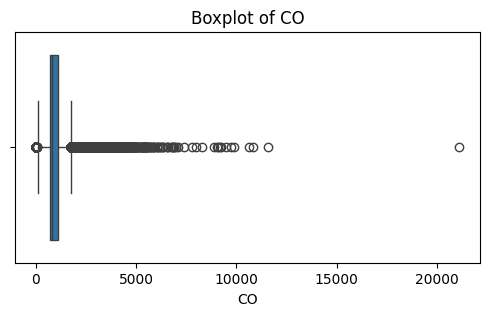

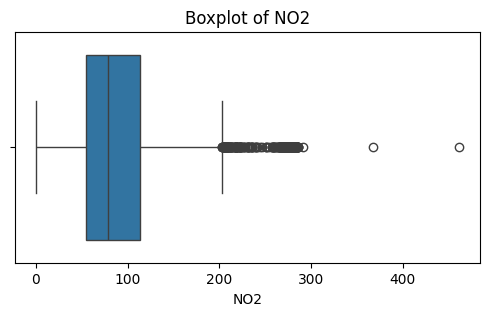

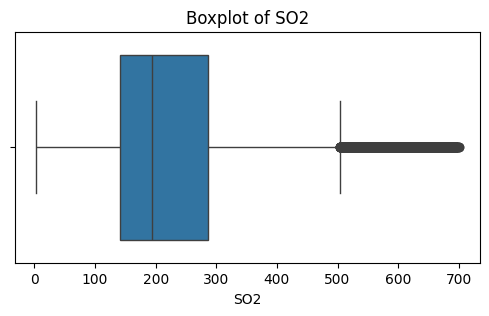

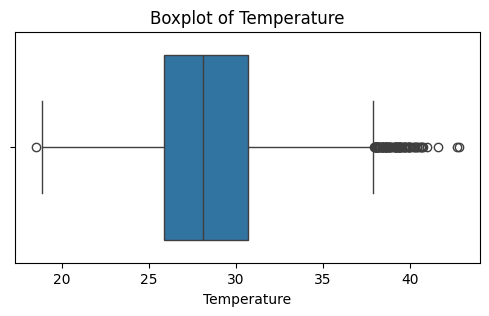

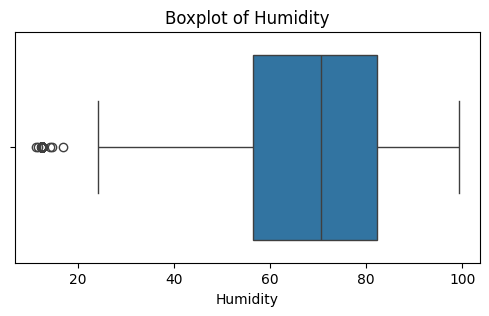

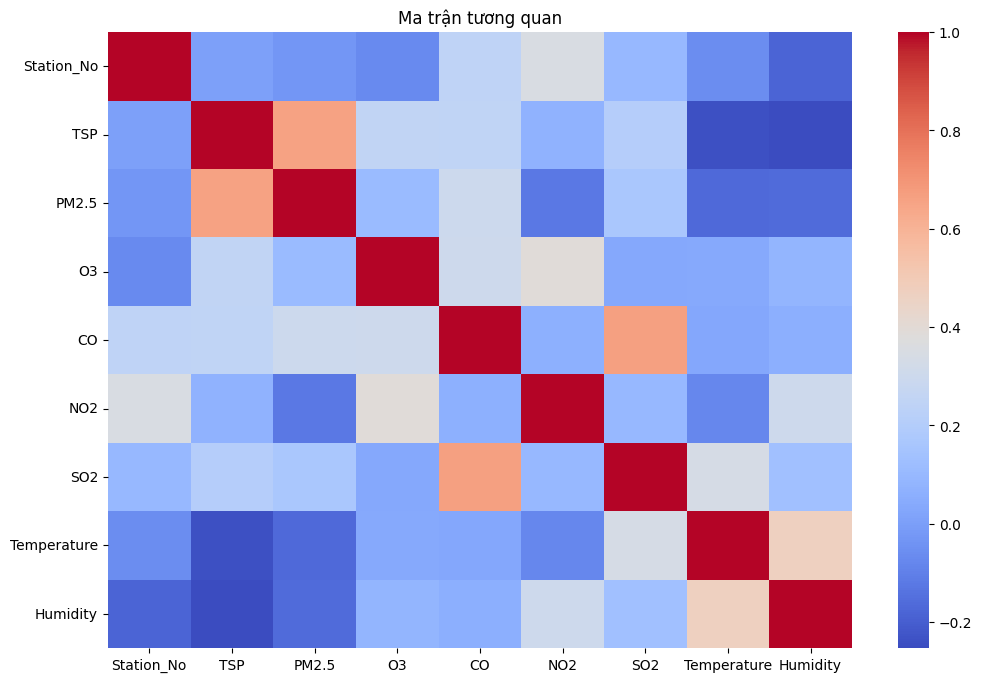

Các cột có NaN:
TSP               60
O3             10610
CO              9065
NO2             5666
SO2            11006
Temperature     4437
Humidity        4432
dtype: int64


In [4]:
print(df.head())
print(df.info())
print(df['Station_No'].value_counts())
print(df.describe())

print("Số bản ghi:", len(df))
print("Thời gian từ", df['date'].min(), "đến", df['date'].max())
print(df.groupby("Station_No")['date'].nunique())

#trực quan hóa dữ liệu ban đầu
df.hist(bins=50, figsize=(15, 10))
plt.show()

corr_value = df['CO'].corr(df['PM2.5'])
print(f"Hệ số tương quan CO vs PM2.5: {corr_value:.2f}")

plt.figure(figsize=(6, 4))
sns.scatterplot(x=df['CO'], y=df['PM2.5'], alpha=0.5)
plt.title(f"Tương quan CO vs PM2.5 (corr = {corr_value:.2f})")
plt.xlabel("CO")
plt.ylabel("PM2.5")
plt.show()

features = ['PM2.5','TSP', 'O3', 'CO', 'NO2', 'SO2', 'Temperature', 'Humidity']
for col in features:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

corr = df.drop('date', axis=1).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title("Ma trận tương quan")
plt.show()

# Kiểm tra dữ liệu NaN
nan_counts = df.isna().sum()
cols_with_nan = nan_counts[nan_counts > 0]
print("Các cột có NaN:")
print(cols_with_nan)


## Tiền xử lý

In [5]:
df['date'] = pd.to_datetime(df['date'])
df.sort_values(['Station_No', 'date'], inplace=True)
df_interpolation = df.interpolate(method='linear', axis=0)


save_dir = "/content/drive/MyDrive/bi-LSTM, RNN, GRU/Data2"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "data_interpolated.csv")

df_interpolation.to_csv(save_path, index=False)
df_interpolation_af = pd.read_csv(save_path)


df_interpolation_af['date'] = pd.to_datetime(df_interpolation_af['date'], errors='coerce')

nan_counts = df_interpolation_af.isna().sum()
cols_with_nan = nan_counts[nan_counts > 0]
print("Các cột có NaN sau nội suy:")
print(cols_with_nan)

# Xử lý ngoại lai và giá trị phi lý
df_interpolation_af.loc[df_interpolation_af['PM2.5'] > 1000, 'PM2.5'] = np.nan
df_interpolation_af.loc[df_interpolation_af['CO'] > 50, 'CO'] = np.nan
df_interpolation_af.loc[(df_interpolation_af['Temperature'] < 5) | (df_interpolation_af['Temperature'] > 50), 'Temperature'] = np.nan

if (df_interpolation_af['CO'] == 0).all():
    print("Cảnh báo: CO toàn bộ = 0, bỏ cột này khỏi feature_columns")
    df_interpolation_af.drop(columns=['CO'], inplace=True)
else:
    median_co = df_interpolation_af.loc[df_interpolation_af['CO'] > 0, 'CO'].median()
    df_interpolation_af['CO'] = df_interpolation_af['CO'].apply(lambda x: median_co if x <= 0 else x)

for station in df_interpolation_af['Station_No'].unique():
    mask = df_interpolation_af['Station_No'] == station
    df_interpolation_af.loc[mask, 'CO'] = df_interpolation_af.loc[mask, 'CO'].interpolate(method='linear', limit=6)

exclude_cols = ['date', 'Station_No']
for col in df.columns:
    if col not in exclude_cols:
        Q1, Q3 = df[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower, upper = Q1 - 3 * IQR, Q3 + 3 * IQR
        df_interpolation_af[col] = np.clip(df_interpolation_af[col], lower, upper)

# Xử lý NaN sau khi xử lý ngoại lai (bổ sung bước này để không lỗi khi đánh giá)
df_interpolation_af = df_interpolation_af.interpolate(method='linear', axis=0)
df_interpolation_af = df_interpolation_af.dropna()

# Encode Station_No
station_features = []
if 'Station_No' in df_interpolation_af.columns and df_interpolation_af['Station_No'].nunique() > 1:
    enc = OneHotEncoder(handle_unknown='ignore')
    station_encoded = enc.fit_transform(df_interpolation_af[['Station_No']])
    station_df = pd.DataFrame(station_encoded.toarray(), columns=[f"station_{i}" for i in range(station_encoded.shape[1])])
    df_interpolation_af = pd.concat([df_interpolation_af.reset_index(drop=True), station_df.reset_index(drop=True)], axis=1)
    station_features = [f"station_{i}" for i in range(station_encoded.shape[1])]

df_interpolation_af['hour'] = df_interpolation_af['date'].dt.hour
df_interpolation_af['dayofweek'] = df_interpolation_af['date'].dt.dayofweek
df_interpolation_af['month'] = df_interpolation_af['date'].dt.month
df_interpolation_af['is_weekend'] = (df_interpolation_af['dayofweek'] >= 5).astype(int)

feature_columns = ['TSP', 'O3', 'CO', 'NO2', 'SO2', 'Temperature', 'Humidity',
                   'hour', 'dayofweek', 'month', 'is_weekend'] + station_features
target_column = 'PM2.5'

X = df_interpolation_af[feature_columns].values
y = df_interpolation_af[[target_column]].values

log_transform_target = True
if log_transform_target:
    y = np.log1p(y)
    scaler_y = RobustScaler()
else:
    scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

def create_sequences(X, y, lookback=72):
    X_seq, y_seq = [], []
    for i in range(len(X) - lookback):
        X_seq.append(X[i:i+lookback])
        y_seq.append(y[i+lookback])
    return np.array(X_seq), np.array(y_seq)

lookback = 72
X_seq, y_seq = create_sequences(X, y_scaled, lookback)
print(f"Raw sequences shape: X={X_seq.shape}, y={y_seq.shape}")


/tmp/ipython-input-1692735388.py:1: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date'] = pd.to_datetime(df['date'])


Các cột có NaN sau nội suy:
Series([], dtype: int64)
Raw sequences shape: X=(50294, 72, 17), y=(50294, 1)


## Train/Test

In [6]:

train_size = int(len(X_seq) * 0.8)
val_size = int(len(X_seq) * 0.1)

X_train = X_seq[:train_size]
y_train = y_seq[:train_size]
X_val = X_seq[train_size:train_size+val_size]
y_val = y_seq[train_size:train_size+val_size]
X_test = X_seq[train_size+val_size:]
y_test = y_seq[train_size+val_size:]

print(f"Data split:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Data split:
X_train: (40235, 72, 17), y_train: (40235, 1)
X_val: (5029, 72, 17), y_val: (5029, 1)
X_test: (5030, 72, 17), y_test: (5030, 1)


## Model Bi-LSTM, RNN, GRU


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout, SimpleRNN, GRU

def build_bilstm(input_shape):
    model = Sequential([
        Bidirectional(LSTM(64, activation='tanh'), input_shape=input_shape),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def build_rnn(input_shape):
    model = Sequential([
        SimpleRNN(64, activation='tanh', input_shape=input_shape),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def build_gru(input_shape):
    model = Sequential([
        GRU(64, activation='tanh', input_shape=input_shape),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model



In [8]:
EPOCHS = 10
BATCH_SIZE = 64
input_shape = (X_train.shape[1], X_train.shape[2])

In [9]:
model_bilstm = build_bilstm(input_shape)
history_bilstm = model_bilstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)
model_bilstm.save(os.path.join(save_dir, "model_bilstm.keras"))



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 54s 79ms/step - loss: 0.4685 - mae: 0.5107 - val_loss: 0.3040 - val_mae: 0.3274
Epoch 2/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 49s 77ms/step - loss: 0.2709 - mae: 0.3802 - val_loss: 0.2075 - val_mae: 0.3076
Epoch 3/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 92s 93ms/step - loss: 0.2414 - mae: 0.3561 - val_loss: 0.1274 - val_mae: 0.2559
Epoch 4/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 73s 79ms/step - loss: 0.2296 - mae: 0.3466 - val_loss: 0.1508 - val_mae: 0.2757
Epoch 5/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 84s 83ms/step - loss: 0.2228 - mae: 0.3388 - val_loss: 0.1391 - val_mae: 0.2759
Epoch 6/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 82s 83ms/step - loss: 0.2180 - mae: 0.3352 - val_loss: 0.1741 - val_mae: 0.2775
Epoch 7/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 80s 80ms/step - loss: 0.2166 - mae: 0.3333 - val_loss: 0.1393 - val_mae: 0.2610
Epoch 8/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 84s 83ms/step - loss: 0.2097 - mae: 0.3276 - val_loss: 0.1020 - val_mae: 0.2269
Epoch 9/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 

In [10]:
model_rnn = build_rnn(input_shape)
history_rnn = model_rnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)
model_rnn.save(os.path.join(save_dir, "model_rnn.keras"))




/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 0.7106 - mae: 0.6443 - val_loss: 0.4573 - val_mae: 0.4232
Epoch 2/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.4010 - mae: 0.4674 - val_loss: 0.3332 - val_mae: 0.3398
Epoch 3/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.3476 - mae: 0.4301 - val_loss: 0.2998 - val_mae: 0.3917
Epoch 4/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.3099 - mae: 0.4044 - val_loss: 0.2736 - val_mae: 0.3503
Epoch 5/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.2933 - mae: 0.3910 - val_loss: 0.2204 - val_mae: 0.3327
Epoch 6/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.2856 - mae: 0.3851 - val_loss: 0.2209 - val_mae: 0.3315
Epoch 7/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.2828 - mae: 0.3824 - val_loss: 0.1363 - val_mae: 0.2758
Epoch 8/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.2728 - mae: 0.3723 - val_loss: 0.1625 - val_mae: 0.2837
Epoch 9/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 

In [11]:
model_gru = build_gru(input_shape)
history_gru = model_gru.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)
model_gru.save(os.path.join(save_dir, "model_gru.h5"))

Epoch 1/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - loss: 0.5092 - mae: 0.5400 - val_loss: 0.3682 - val_mae: 0.4471
Epoch 2/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step - loss: 0.2919 - mae: 0.4025 - val_loss: 0.2261 - val_mae: 0.3716
Epoch 3/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 40s 59ms/step - loss: 0.2596 - mae: 0.3778 - val_loss: 0.1750 - val_mae: 0.3232
Epoch 4/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - loss: 0.2407 - mae: 0.3611 - val_loss: 0.2280 - val_mae: 0.3587
Epoch 5/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step - loss: 0.2262 - mae: 0.3492 - val_loss: 0.1500 - val_mae: 0.2912
Epoch 6/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - loss: 0.2154 - mae: 0.3401 - val_loss: 0.1538 - val_mae: 0.2963
Epoch 7/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step - loss: 0.2115 - mae: 0.3362 - val_loss: 0.1467 - val_mae: 0.2841
Epoch 8/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - loss: 0.2066 - mae: 0.3293 - val_loss: 0.1472 - val_mae: 0.2921
Epoch 9/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 

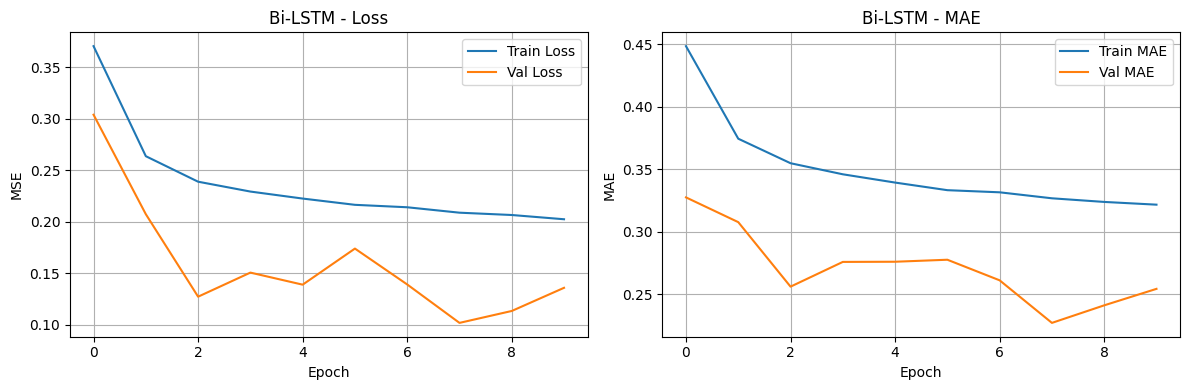

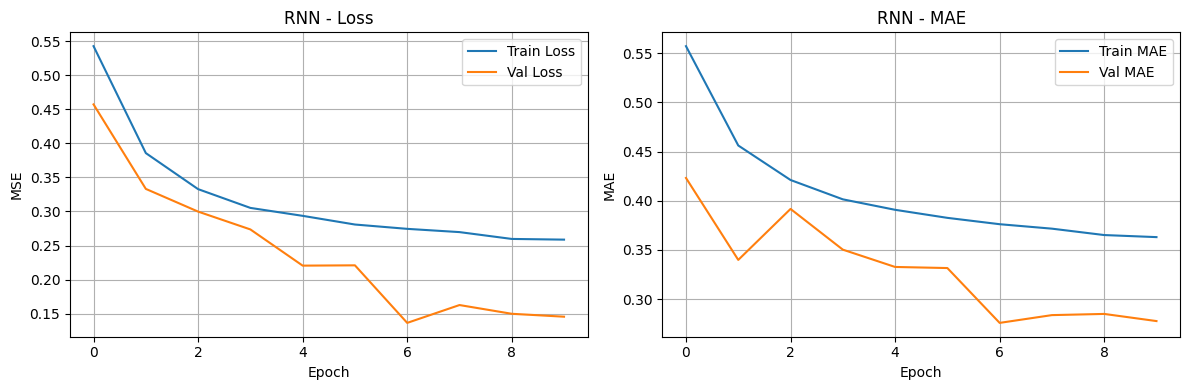

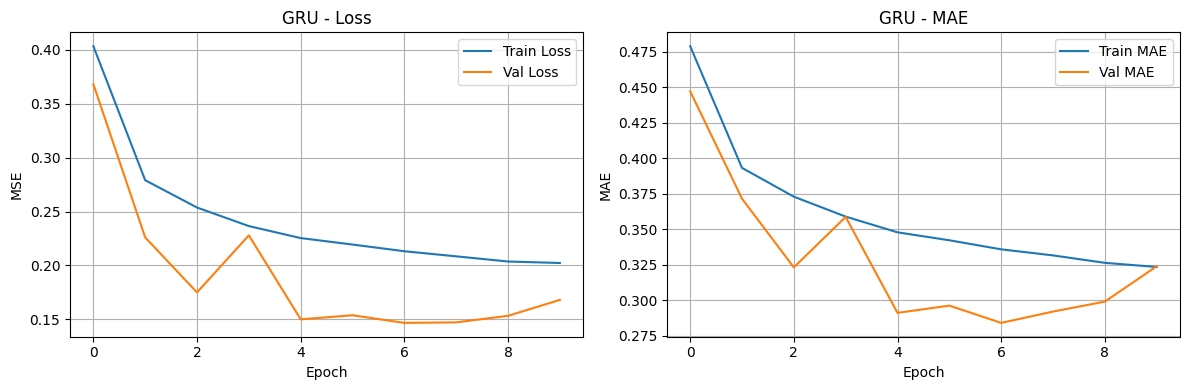

158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


In [12]:
def plot_loss_mae(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title(f'{title} - MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_loss_mae(history_bilstm, "Bi-LSTM")
plot_loss_mae(history_rnn, "RNN")
plot_loss_mae(history_gru, "GRU")

def inverse_pm25(y_scaled, scaler_y, log_transform=True):
    y_unscaled = scaler_y.inverse_transform(y_scaled.reshape(-1, 1)).flatten()
    if log_transform:
        y_unscaled = np.expm1(y_unscaled)
    return y_unscaled

# Dự báo trên tập test
y_pred_bilstm = model_bilstm.predict(X_test)
y_pred_rnn = model_rnn.predict(X_test)
y_pred_gru = model_gru.predict(X_test)

y_test_orig = inverse_pm25(y_test, scaler_y, log_transform=True)
y_pred_bilstm_orig = inverse_pm25(y_pred_bilstm, scaler_y, log_transform=True)
y_pred_rnn_orig = inverse_pm25(y_pred_rnn, scaler_y, log_transform=True)
y_pred_gru_orig = inverse_pm25(y_pred_gru, scaler_y, log_transform=True)

# Loại bỏ các giá trị NaN/Infs còn sót lại (để không lỗi khi evaluate)
def clean_nan_inf(y):
    y = np.array(y)
    y = y[~np.isnan(y)]
    y = y[~np.isinf(y)]
    return y


---- Đánh giá Bi-LSTM ----
MAE: 4.024 | RMSE: 6.308 | R^2: 0.628 | MAPE: 16.52%

---- Đánh giá RNN ----
MAE: 3.949 | RMSE: 5.849 | R^2: 0.680 | MAPE: 17.67%

---- Đánh giá GRU ----
MAE: 4.210 | RMSE: 5.892 | R^2: 0.675 | MAPE: 20.52%


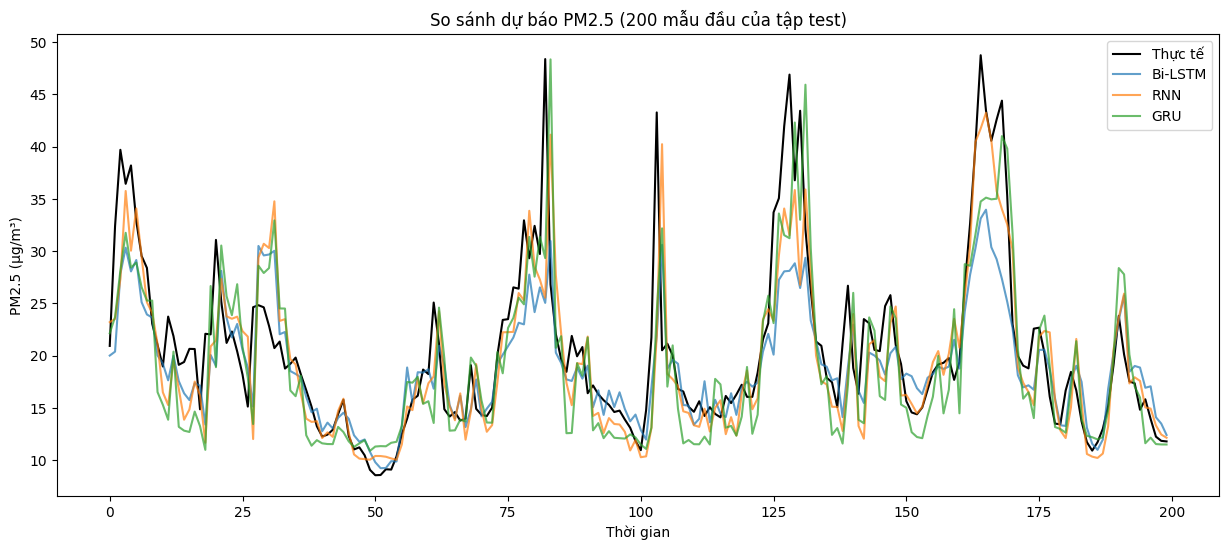

In [13]:
# Đảm bảo độ dài y_true và y_pred bằng nhau, loại bỏ NaN/infs
def safe_evaluate(y_true, y_pred):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    mask = (~np.isnan(y_true)) & (~np.isnan(y_pred)) & (~np.isinf(y_true)) & (~np.isinf(y_pred))
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    print(f"MAE: {mae:.3f} | RMSE: {rmse:.3f} | R^2: {r2:.3f} | MAPE: {mape:.2f}%")
    return mae, mse, rmse, r2, mape

print("\n---- Đánh giá Bi-LSTM ----")
safe_evaluate(y_test_orig, y_pred_bilstm_orig)
print("\n---- Đánh giá RNN ----")
safe_evaluate(y_test_orig, y_pred_rnn_orig)
print("\n---- Đánh giá GRU ----")
safe_evaluate(y_test_orig, y_pred_gru_orig)


plt.figure(figsize=(15,6))
plt.plot(y_test_orig[:200], label='Thực tế', color='black')
plt.plot(y_pred_bilstm_orig[:200], label='Bi-LSTM', alpha=0.7)
plt.plot(y_pred_rnn_orig[:200], label='RNN', alpha=0.7)
plt.plot(y_pred_gru_orig[:200], label='GRU', alpha=0.7)
plt.title("So sánh dự báo PM2.5 (200 mẫu đầu của tập test)")
plt.xlabel("Thời gian")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.show()

In [14]:
!git clone https://github.com/pvnhuong2405/Short-term-Forecasting-of-PM2.5-Concentration-for-the-Next-Hour-at-a-Single-Monitoring-Station.git

Cloning into 'Short-term-Forecasting-of-PM2.5-Concentration-for-the-Next-Hour-at-a-Single-Monitoring-Station'...


In [15]:
!cp "/content/drive/MyDrive/bi-LSTM, RNN, GRU/PM2.5(t+1).ipynb" "/content/Short-term-Forecasting-of-PM2.5-Concentration-for-the-Next-Hour-at-a-Single-Monitoring-Station/"
!cp "/content/drive/MyDrive/bi-LSTM, RNN, GRU/Data/AirQualityHoChiMinhCity.csv" "/content/Short-term-Forecasting-of-PM2.5-Concentration-for-the-Next-Hour-at-a-Single-Monitoring-Station/"


cp: cannot stat '/content/drive/MyDrive/bi-LSTM, RNN, GRU/Data/AirQualityHoChiMinhCity.csv': No such file or directory
